## Decision tree, Greedy bisection idea

ref. https://youtu.be/LDRbO9a6XPU

notebook https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb

In [38]:
import numpy as np
import pandas as pd
from itertools import combinations, chain

df = pd.DataFrame([
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
], columns=['color', 'diameter', 'label'])

df['color'] = df['color'].astype('category')
df['label'] = df['label'].astype('category')

In [2]:
def gini_index(df: pd.DataFrame):
    if len(df) < 1:
        return 0.0
    
    gini = df['label'].value_counts(normalize=True).values
    gini = gini * (1.0 - gini)
    return gini.sum()
    
    
def gini_sum_branches(df, sack):
    gini = gini_index(df[sack]) + gini_index(df[~sack])
    return gini

In [98]:
def ds_partitions(ds):
    if ds.dtype.kind == 'O':
        s = ds.unique()
        partitions = chain.from_iterable([combinations(s, k) for k in range(len(s) // 2 + 1)])
        partitions = [set(el) for el in partitions]
    else:
        s = ds.unique()
        s = sorted(s)
        partitions = map(lambda x: s[:x], range(len(s)))
        partitions = list(partitions)
    return [partitions]

### 1st branch

In [99]:
partitions = df.iloc[:, :-1].agg(ds_partitions)
partitions = partitions.agg(lambda ds: {k: v for k, v in zip(ds.index, ds)}, axis=1)
partitions = partitions[0]
partitions

{'color': [set(), {'Green'}, {'Yellow'}, {'Red'}], 'diameter': [[], [1]]}

In [123]:
from itertools import repeat

gini = map(
    lambda x: [(k1, v1) for k1, v1 in zip(repeat(x[0]), x[1])],
    partitions.items())
gini = chain.from_iterable(gini)
gini = map(lambda x: (
    *x, df[x[0]].isin(x[1])), gini)
gini = map(lambda x: (
    *x[:-1], gini_sum_branches(df, x[-1])
), gini)
gini = sorted(gini, key=lambda x: x[-1])
gini

[('color', {'Red'}, 0.4444444444444445),
 ('diameter', [1], 0.4444444444444445),
 ('color', {'Green'}, 0.625),
 ('color', set(), 0.64),
 ('diameter', [], 0.64),
 ('color', {'Yellow'}, 0.9444444444444444)]

In [125]:
k, v, _ = gini[0]  # best partition
dfs = df[df[k].isin(v)], df[~df[k].isin(v)]

In [129]:
dfs[0]

,color,diameter,label
2,Red,1,Grape
3,Red,1,Grape


In [130]:
dfs[1]

,color,diameter,label
0,Green,3,Apple
1,Yellow,3,Apple
4,Yellow,3,Lemon


### 2nd branch

In [131]:
df = dfs[1].copy()

partitions = df.iloc[:, :-1].agg(ds_partitions)
partitions = partitions.agg(lambda ds: {k: v for k, v in zip(ds.index, ds)}, axis=1)
partitions = partitions[0]
partitions

{'color': [set(), {'Green'}, {'Yellow'}], 'diameter': [[]]}

In [133]:
gini = map(
    lambda x: [(k1, v1) for k1, v1 in zip(repeat(x[0]), x[1])],
    partitions.items())
gini = chain.from_iterable(gini)
gini = map(lambda x: (
    *x, df[x[0]].isin(x[1])), gini)
gini = map(lambda x: (
    *x[:-1], gini_sum_branches(df, x[-1])
), gini)
gini = sorted(gini, key=lambda x: x[-1])
gini

[('color', set(), 0.4444444444444445),
 ('diameter', [], 0.4444444444444445),
 ('color', {'Green'}, 0.5),
 ('color', {'Yellow'}, 0.5)]

### nothing can be done any more

## scikit-learn decision tree classifier

In [135]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
iris = load_iris()

In [179]:
df = pd.DataFrame(iris['data'], columns=['sl', 'sw', 'pl', 'pw'])
df['label'] = iris['target']
df.head()

,sl,sw,pl,pw,label
0,5.1,3.5,1.4,0.1,0
1,4.9,3.0,1.4,0.1,0
2,4.7,3.2,1.3,0.1,0
3,4.6,3.1,1.5,0.1,0
4,5.0,3.6,1.4,0.1,0


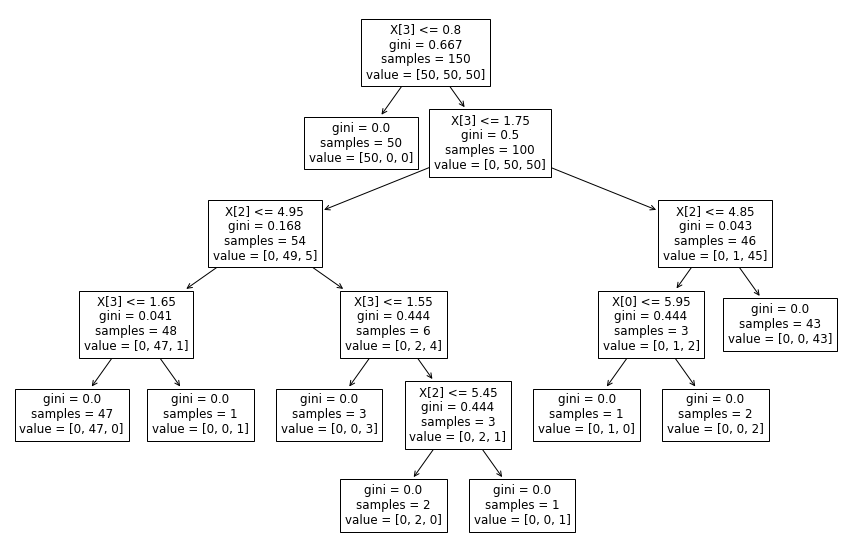

In [149]:
import matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline


plt.figure(figsize=(15, 10))
clf = clf.fit(iris.data, iris.target)
tree.plot_tree(clf);

### The same result drawn by greedy branching

In [171]:
partitions = df.iloc[:, :-1].agg(ds_partitions)
partitions = partitions.apply(lambda x: x[0])
partitions = map(
    lambda x: [(k, v) for k, v in zip(repeat(x[0]), x[1])],
    zip(partitions.index, partitions))
partitions = chain.from_iterable(partitions)
partitions = list(partitions)

In [172]:
gini = map(lambda x: (
    *x, df[x[0]].isin(x[1])), partitions)
gini = map(lambda x: (
    *x[:-1], gini_sum_branches(df, x[-1])
), gini)
gini = sorted(gini, key=lambda x: x[-1])
gini = list(gini)

In [173]:
gini[:5]

[('pl', [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.9], 0.5),
 ('pw', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 0.5),
 ('pw', [0.1, 0.2, 0.3, 0.4, 0.5], 0.5097539456915989),
 ('pl', [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7], 0.5190311418685121),
 ('pw', [0.1, 0.2, 0.3, 0.4], 0.5190311418685121)]

In [193]:
np.sort(np.array(list(set(df['pw'].values)), dtype=np.float))

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,
       1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5])

# Surrogate splits

https://www.ismll.uni-hildesheim.de/lehre/ml-09w/script/ml-04-decisiontrees-2up.pdf

In [1]:
import pandas as pd

df = pd.DataFrame({
    'referer': list('ssoaaooa'),
    'visits': list('sosooooo'),
    'duration': [15, 10, 5, 15, 10, 10, 5, 5],
    'buyer': [1, 1, 1, 1, 0, 0, 0, 0]
})
df

,referer,visits,duration,buyer
0,s,s,15,1
1,s,o,10,1
2,o,s,5,1
3,a,o,15,1
4,a,o,10,0
5,o,o,10,0
6,o,o,5,0
7,a,o,5,0


In [4]:
df['primary_split'] = df['duration'] < 12.5
df['surrogate_1'] = df['referer'] == 's'
df['surrogate_2'] = df['referer'] == 'o'
df['surrogate_3'] = df['referer'] == 'a'
df['surrogate_4'] = df['visits'] == 's'
df

,referer,visits,duration,buyer,primary_split,surrogate_1,surrogate_2,surrogate_3,surrogate_4
0,s,s,15,1,False,True,False,False,True
1,s,o,10,1,True,True,False,False,False
2,o,s,5,1,True,False,True,False,True
3,a,o,15,1,False,False,False,True,False
4,a,o,10,0,True,False,False,True,False
5,o,o,10,0,True,False,True,False,False
6,o,o,5,0,True,False,True,False,False
7,a,o,5,0,True,False,False,True,False


In [21]:
df_s = df[['surrogate_1', 'surrogate_2', 'surrogate_3', 'surrogate_4',]].agg(
    lambda ds: (df['primary_split'] == ds).sum())
df_s = df_s.to_frame()
df_s[1] = 8 - df_s
df_s[2] = df_s.max(axis=1)
df_s['primay_frac'] = df_s[2] / 8
df_s

,0,1,2,primay_frac
surrogate_1,2,6,6,0.750
surrogate_2,5,3,5,0.625
surrogate_3,3,5,5,0.625
surrogate_4,2,6,6,0.750


* The best two surrogates are surrogate_1, 4